In [37]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score, roc_auc_score,
    confusion_matrix, classification_report, RocCurveDisplay, ConfusionMatrixDisplay,
)

In [5]:
df = pd.read_csv("/content/drive/MyDrive/praktikum_ML/praktikum04/data/stunting_wasting_dataset.csv")
df.head()

,Jenis Kelamin,Umur (bulan),Tinggi Badan (cm),Berat Badan (kg),Stunting,Wasting
0,Laki-laki,19,91.6,13.3,Tall,Risk of Overweight
1,Laki-laki,20,77.7,8.5,Stunted,Underweight
2,Laki-laki,10,79.0,10.3,Normal,Risk of Overweight
3,Perempuan,2,50.3,8.3,Severely Stunted,Risk of Overweight
4,Perempuan,5,56.4,10.9,Severely Stunted,Risk of Overweight


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 6 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   Jenis Kelamin      100000 non-null  object 
 1   Umur (bulan)       100000 non-null  int64  
 2   Tinggi Badan (cm)  100000 non-null  float64
 3   Berat Badan (kg)   100000 non-null  float64
 4   Stunting           100000 non-null  object 
 5   Wasting            100000 non-null  object 
dtypes: float64(2), int64(1), object(3)
memory usage: 4.6+ MB


In [7]:
#cek missing value
df.isnull().sum()

,0
Jenis Kelamin,0
Umur (bulan),0
Tinggi Badan (cm),0
Berat Badan (kg),0
Stunting,0
Wasting,0


In [17]:
df.duplicated().sum()

np.int64(7308)

In [18]:
df = df.drop_duplicates()

In [19]:
df.duplicated().sum()

np.int64(0)

In [22]:
df['Stunting'].unique()

array(['Tall', 'Stunted', 'Normal', 'Severely Stunted'], dtype=object)

In [23]:
df['Jenis Kelamin'].unique()

array(['Laki-laki', 'Perempuan'], dtype=object)

In [24]:
map_stunt = {'Stunted' : 1, "Severly Stunted" : 1,'Normal' : 0, 'Tall' : 0}
df['Stunting_bin'] = df['Stunting'].map(map_stunt).astype('Int64')

df['JK_bin'] = (df['Jenis Kelamin'] == 'Laki-Laki').astype(int)

print("Distribusi Stunting_bin:\n", df['Stunting_bin'].value_counts())
print("\nDistribusi JK_bin:\n", df['JK_bin'].value_counts())

Distribusi Stunting_bin:
 Stunting_bin
0    72320
1    15039
Name: count, dtype: Int64

Distribusi JK_bin:
 JK_bin
0    92692
Name: count, dtype: int64


/tmp/ipython-input-3348554216.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Stunting_bin'] = df['Stunting'].map(map_stunt).astype('Int64')
/tmp/ipython-input-3348554216.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['JK_bin'] = (df['Jenis Kelamin'] == 'Laki-Laki').astype(int)


In [25]:
corr_matrix = df.corr(numeric_only=True)
corr_matrix

,Umur (bulan),Tinggi Badan (cm),Berat Badan (kg),Stunting_bin,JK_bin
Umur (bulan),1.000000,0.874162,0.659566,0.060457,NaN
Tinggi Badan (cm),0.874162,1.000000,0.618453,-0.228848,NaN
Berat Badan (kg),0.659566,0.618453,1.000000,0.036985,NaN
Stunting_bin,0.060457,-0.228848,0.036985,1.000000,NaN
JK_bin,NaN,NaN,NaN,NaN,NaN


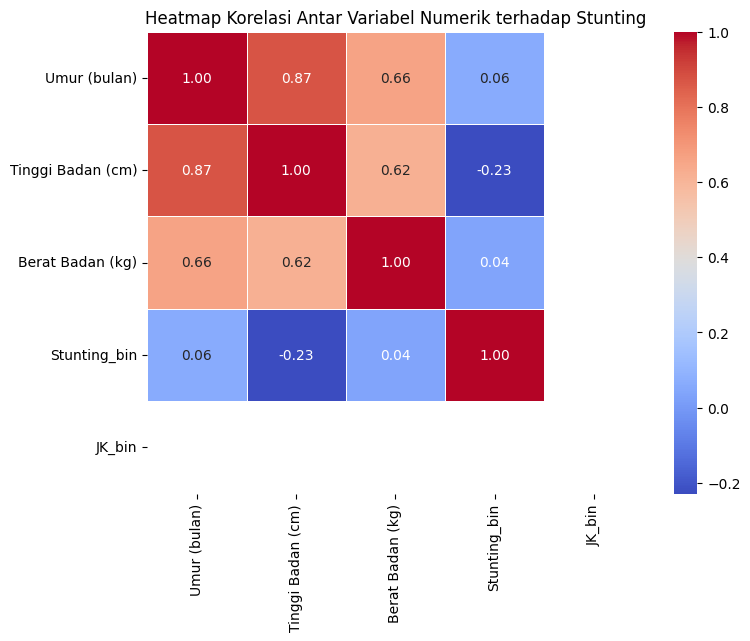

In [26]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(8,6))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title('Heatmap Korelasi Antar Variabel Numerik terhadap Stunting', fontsize=12)
plt.show()

In [28]:
feature_num = ['Umur (bulan)', 'Tinggi Badan (cm)', 'Berat Badan (kg)']
feature_bin = ['JK_bin']

use_cols = feature_num + feature_bin + ['Stunting_bin']
df_model = df[use_cols].dropna().copy()

x = df_model[feature_num + feature_bin]
y = df_model['Stunting_bin']

print("x shape:", x.shape)
print("y shape:", y.shape)

x shape: (87359, 4)
y shape: (87359,)


In [29]:
X_train, X_test, y_train, y_test = train_test_split(
    x, y,
    test_size=0.2,
    random_state=42,
    stratify=y
    )
print("Data latih:", X_train.shape)
print("Data uji:", X_test.shape)

Data latih: (69887, 4)
Data uji: (17472, 4)


In [32]:
preprocess = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), feature_num),
        ('bin', 'passthrough', feature_bin)
    ],
    remainder='drop'
)

model = LogisticRegression(
    max_iter=1000,
    solver='lbfgs',
    class_weight='balanced',
    random_state=42
)

clf = Pipeline([
    ('preprocess', preprocess),
    ('model', model)
])

# Latih model
clf.fit(X_train, y_train)
print("✅ Model Logistic Regression berhasil dilatih.")

✅ Model Logistic Regression berhasil dilatih.


In [33]:
y_pred = clf.predict(X_test)
y_prob = clf.predict_proba(X_test)[:, 1]

# Hitung metrik
print(f"Akurasi     : {accuracy_score(y_test, y_pred):.4f}")
print(f"Precision   : {precision_score(y_test, y_pred, zero_division=0):.4f}")
print(f"Recall      : {recall_score(y_test, y_pred, zero_division=0):.4f}")
print(f"F1-Score    : {f1_score(y_test, y_pred, zero_division=0):.4f}")
print(f"ROC-AUC     : {roc_auc_score(y_test, y_prob):.4f}")

Akurasi     : 0.8750
Precision   : 0.5878
Recall      : 0.9172
F1-Score    : 0.7164
ROC-AUC     : 0.9519


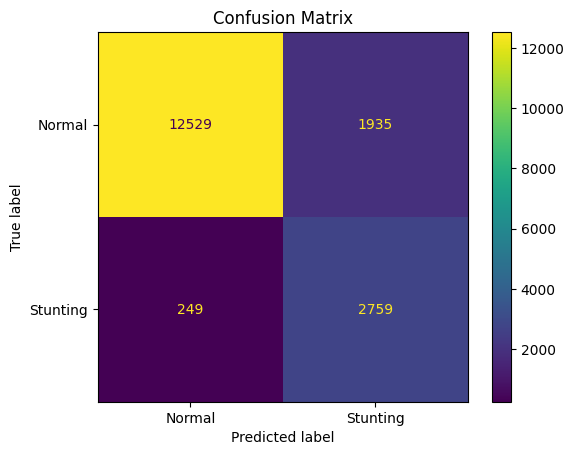

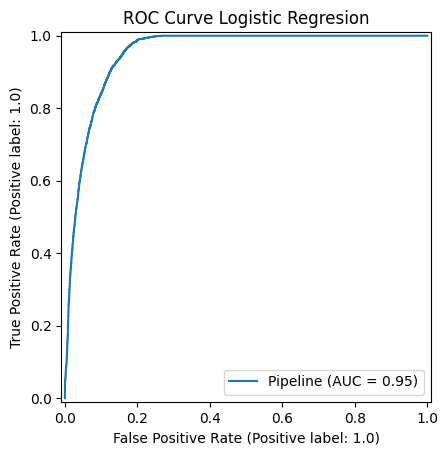

In [35]:
ConfusionMatrixDisplay(confusion_matrix(y_test, y_pred),
                       display_labels=['Normal','Stunting']
                       ).plot(values_format='d')
plt.title('Confusion Matrix')
plt.show()

RocCurveDisplay.from_estimator(clf, X_test, y_test)
plt.title('ROC Curve Logistic Regresion')
plt.show()

In [39]:
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred, target_names=['Tidak Stunting(0)','Stunting(1)']))

                   precision    recall  f1-score   support

Tidak Stunting(0)       0.98      0.87      0.92     14464
      Stunting(1)       0.59      0.92      0.72      3008

         accuracy                           0.88     17472
        macro avg       0.78      0.89      0.82     17472
     weighted avg       0.91      0.88      0.88     17472



In [40]:
from sklearn.model_selection import cross_val_score

scores = cross_val_score(clf, x, y, cv=5)

print("skor tiap fold:", scores)
print("rata-rata skor:", np.mean(scores))
print("Standar deviasi:", np.std(scores))

skor tiap fold: [0.87706044 0.87099359 0.87156593 0.8751717  0.86995593]
rata-rata skor: 0.8729495187262704
Standar deviasi: 0.0027033065198944824


In [43]:
feature_names = feature_num + feature_bin
coefs = clf.named_steps['model'].coef_[0]
odds = np.exp(coefs)

coef_df = pd.DataFrame({
    'Fitur': feature_names,
    'Koefisien (log-odds)': coefs,
    'Odds Ratio (e^coef)': odds
}).sort_values(by='Odds Ratio (e^coef)', ascending=False)

display(coef_df)

,Fitur,Koefisien (log-odds),Odds Ratio (e^coef)
0,Umur (bulan),7.165505,1294.014418
2,Berat Badan (kg),0.652213,1.919784
3,JK_bin,0.000000,1.000000
1,Tinggi Badan (cm),-8.839479,0.000145


In [44]:
data_baru = pd.DataFrame({
    'Umur (bulan)':[24,10],
    'Tinggi Badan (cm)':[79.0, 72.5],
    'Berat Badan (kg)':[9.2, 7.8],
    'JK_bin':[1,0]
})

pred = clf.predict(data_baru)
prob = clf.predict_proba(data_baru)[:,1]

hasil = data_baru.copy()
hasil['Prob_Stunting'] = prob
hasil['Pred(0=tidak, 1=Ya)'] = pred
display(hasil)

,Umur (bulan),Tinggi Badan (cm),Berat Badan (kg),JK_bin,Prob_Stunting,"Pred(0=tidak, 1=Ya)"
0,24,79.0,9.2,1,0.992188,1.0
1,10,72.5,7.8,0,0.013732,0.0
